In [1]:
from src.scraping.get_data import *
from src.utils.checks import *
from src.portfolio.data_manipulation import *
from src.plots.basics import *
from src.computations.compute_returns import *
from src.computations.metrics import *
from src.utils.basics import *
from src.plots.basics_streamlit import *

get_data_info()
data = get_data_updated_2025()

download_data_updated()

In [2]:
data

,Date,MSCI Europe Small Cap Value Weighted,MSCI USA Small Cap Value Weighted.1,MSCI Europe,MSCI World Momentum,MSCI ACWI,MSCI World,S&P 500 Minimum Volatility,MSCI Emerging Markets,FTSE World Government Bond - Developed Markets,S&P 500,MSCI USA Small Cap Value Weighted
0,01/1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02/1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,03/1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04/1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,05/1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
601,02/2025,151620.912337,332033.356917,771142.176129,278724.388599,243528.409920,1.017283e+06,93364.614043,352456.719356,57818.820684,333427.489458,332033.356917
602,03/2025,149258.620455,301474.781370,740100.039015,253014.321457,225203.342503,9.356841e+05,87854.767453,341488.238952,56062.489396,302887.181519,301474.781370
603,04/2025,151103.730645,274195.338702,734564.922807,248540.215643,215995.891590,8.976836e+05,82429.995779,328764.402587,55177.416831,286073.221001,274195.338702
604,05/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
get_list_of_portfolios()

['100_2factors',
 '80_20_ACWI',
 '80_20_World',
 '80_20_2factors',
 '100_1factor',
 'lifestrategy60',
 'lifestrategy80',
 'lifestrategy20',
 'lifestrategy0',
 'lifestrategy40',
 'lifestrategy100',
 '80_20_1factor',
 '60_40_World']

In [4]:
PORTFOLIOS = [
    '100_2factors',
    '80_20_2factors',
    '80_20_1factor',
    '80_20_ACWI',
    '80_20_World'
]

PORTOFOLIO_NAMES = {
    '100_2factors'  : '100% Stocks + SmallCap Value + Momentum',
    '80_20_2factors': '80% Stocks + 20% Bonds + SmallCap Value + Momentum',
    '80_20_1factor' : '80% Stocks + 20% Bonds + SmallCap Value',
    '80_20_ACWI'    : '80% Stocks(ACWI) + 20% Bonds',
    '80_20_World'   : '80% Stocks(World) + 20% Bonds',
}

PORTFOLIO_DESCRIPTIONS = {
    '100_2factors'  : 'This portfolio invests 100% in stocks, focusing on small-cap value and momentum strategies.',
    '80_20_2factors': 'This portfolio allocates 80% to stocks and 20% to bonds, incorporating small-cap value and momentum factors.',
    '80_20_1factor' : 'This portfolio invests 80% in stocks and 20% in bonds, focusing on small-cap value.',
    '80_20_ACWI'    : 'This portfolio invests 80% in global stocks (ACWI) and 20% in bonds.',
    '80_20_World'   : 'This portfolio invests 80% in world stocks and 20% in bonds.'
}

# Add another group of portfolios in col2
SIMPLE_PORTFOLIOS = [
    'lifestrategy100',
    'lifestrategy80',
    'lifestrategy60',
    'lifestrategy40',
    'lifestrategy20',
    'lifestrategy0'
]

SIMPLE_PORTFOLIO_NAMES = {
    'lifestrategy100': '100% Stocks',
    'lifestrategy80' : '80% Stocks + 20% Bonds',
    'lifestrategy60' : '60% Stocks + 40% Bonds',
    'lifestrategy40' : '40% Stocks + 60% Bonds',
    'lifestrategy20' : '20% Stocks + 80% Bonds',
    'lifestrategy0'  : '100% Bonds'
}

SIMPLE_PORTFOLIO_DESCRIPTIONS = {
    'lifestrategy100': 'This portfolio invests 100% in stocks, suitable for aggressive strategies seeking high growth. Note that stocks are MSCI World',
    'lifestrategy80' : 'This portfolio allocates 80% to stocks and 20% to bonds, balancing growth and stability. Stocks are MSCI World',
    'lifestrategy60' : 'This portfolio invests 60% in stocks and 40% in bonds, providing moderate growth with some stability. Stocks are MSCI World',
    'lifestrategy40' : 'This portfolio invests 40% in stocks and 60% in bonds, focusing on stability with some growth potential. Stocks are MSCI World',
    'lifestrategy20' : 'This portfolio invests 20% in stocks and 80% in bonds, prioritizing stability with minimal growth. Stocks are MSCI World',
    'lifestrategy0'  : 'This portfolio invests 100% in bonds, suitable for conservative strategies seeking capital preservation.'
}

ALL_PORTFOLIOS = PORTFOLIOS + SIMPLE_PORTFOLIOS
ALL_PORTFOLIOS

['100_2factors',
 '80_20_2factors',
 '80_20_1factor',
 '80_20_ACWI',
 '80_20_World',
 'lifestrategy100',
 'lifestrategy80',
 'lifestrategy60',
 'lifestrategy40',
 'lifestrategy20',
 'lifestrategy0']

In [5]:
DEFAULT_LAYOUT = {
    "template": "simple_white",
    "width": 1200,
    "height": 800,
    "legend_title": "Portfolio",
    "title_font_size": 25,
    "title_font_family": "Arial",
    "legend": dict(font=dict(size=22)),
    "xaxis": dict(
        tickformat="%Y",
        title_font=dict(size=22, color="black", family="Arial"),
        tickfont=dict(size=16, color="black"),
        linecolor="black",
        linewidth=2,
        showgrid=True,
        gridcolor="lightgray",
        gridwidth=1
    ),
    "yaxis": dict(
        title_font=dict(size=22, color="black", family="Arial"),
        tickfont=dict(size=16, color="black"),
        linecolor="black",
        tickformat=".1f",           # Show one decimal
        tickprefix="",              # No prefix needed; suffix adds %
        ticksuffix="%",            # ✅ Add percent sign without multiplying
        linewidth=2,
        showgrid=True,
        gridcolor="lightgray",
        gridwidth=1
    ),
    "font": dict(color="black")
}

In [ ]:
def plot_return_distributions_streamlit(df):
    """
    Create an interactive violin plot showing portfolio return distributions,
    with custom median and 5th percentile lines using Plotly and matplotlib colors.
    """
    def _prepare_data(df):
        returns_df = df.dropna(how='all')
        long_df = returns_df.melt(id_vars='Date', var_name='Portfolio', value_name='Return').dropna()
        return long_df

    def _get_colors(portfolios):
        cmap = plt.get_cmap('tab10')
        return {
            p: '#{0:02x}{1:02x}{2:02x}'.format(
                int(255 * r), int(255 * g), int(255 * b)
            )
            for p, (r, g, b, _) in zip(portfolios, cmap(range(len(portfolios))))
        }

    def _get_plot_shapes_and_annotations(medians, p5s, y_positions, colors, line_height=0.6):
        shapes, annotations = [], []
        for portfolio, y_pos in y_positions.items():
            median_val = medians[portfolio]
            p5_val = p5s[portfolio]

            # Median line
            shapes.append(dict(
                type='line', x0=median_val, x1=median_val,
                y0=y_pos - line_height/2, y1=y_pos + line_height/2,
                line=dict(color=colors[portfolio], width=3),
                opacity=1,
                xref='x', yref='y'
            ))
            annotations.append(dict(
                x=median_val, y=y_pos + line_height / 2 + 0.1,
                text=f"Median: {median_val:.2%}",
                showarrow=False,
                font=dict(color=colors[portfolio], size=16),
                xanchor='left'
            ))

            # 5th percentile line
            shapes.append(dict(
                type='line', x0=p5_val, x1=p5_val,
                y0=y_pos - line_height/2, y1=y_pos + line_height/2,
                line=dict(color=colors[portfolio], width=3, dash='dash'),
                opacity=1,
                xref='x', yref='y'
            ))
            annotations.append(dict(
                x=p5_val, y=y_pos - line_height / 2 + 0.65,
                text=f"5th %: {p5_val:.2%}",
                showarrow=False,
                font=dict(color=colors[portfolio], size=16),
                xanchor='left'
            ))

        return shapes, annotations

    # Data preparation
    long_df = _prepare_data(df)
    portfolios = long_df['Portfolio'].unique()
    colors = _get_colors(portfolios)
    plot_height = 230 * len(portfolios)

    # Seaborn style (optional)
    sns.set(style="whitegrid", context="talk")

    # Violin plot
    fig = px.violin(
        long_df,
        y='Portfolio',
        x='Return',
        color='Portfolio',
        box=False,
        points='all',
        color_discrete_map=colors,
        template='simple_white'
    )

    # Order & positioning
    category_order = fig.layout.yaxis.categoryarray or portfolios.tolist()
    y_positions = {p: i for i, p in enumerate(category_order)}

    # Statistics
    medians = long_df.groupby('Portfolio')['Return'].median()
    p5s = long_df.groupby('Portfolio')['Return'].quantile(0.05)
    shapes, annotations = _get_plot_shapes_and_annotations(medians, p5s, y_positions, colors)

    # Final layout update
    fig.update_layout(
        height=plot_height,
        width=1200,
        violingap=0.25,
        violinmode='overlay',
        shapes=shapes,
        annotations=annotations,
        template='simple_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="center",
            x=0.5,
            font=dict(size=22)
        ),
        font=dict(color="black"),
        title_font_size=25,
        title_font_family="Arial",
        title = " ",
        xaxis=dict(
            title="Annualized Return (%)",
            title_font=dict(size=22, color="black", family="Arial"),
            tickfont=dict(size=16, color="black"),
            tickformat=".1%",
            linecolor="black",
            linewidth=2,
            showgrid=True,
            gridcolor="lightgray"
        ),
        yaxis=dict(
            title="Portfolio",
            title_font=dict(size=22, color="black", family="Arial"),
            tickfont=dict(size=16, color="black"),
            linecolor="black",
            linewidth=2,
            showgrid=True,
            gridcolor="lightgray",
            categoryorder='array',
            categoryarray=category_order
        )
    )
        # Customize hover template for each trace
    fig.update_traces(
        hoveron = 'points+kde'
        )
           

    return fig


In [7]:
portfolios = ['100_2factors',
              '80_20_2factors',
              '80_20_1factor',
              '80_20_ACWI',
              '80_20_World']

portfolios = [ 'lifestrategy40',
               'lifestrategy20',
               'lifestrategy0']

for years in [5]:
    final_results = None 
    for portfolio_name in portfolios:

        portfolio = load_portfolio(portfolio_name)
        data, weights = prune_data_portfolio(portfolio)

        # Compute the returns
        results = compute_portfolio_returns_combined(*prune_data_portfolio(portfolio), years=years)
        results = results.rename(columns={results.columns[-1]: portfolio_name})
        results[portfolio_name] = results[portfolio_name].round(5)

        final_results = merge_results(final_results, results)

In [73]:
plot_return_distributions_streamlit(final_results)

In [66]:
def _prepare_data(df):
    returns_df = df.dropna(how='all')
    long_df = returns_df.melt(id_vars='Date', var_name='Portfolio', value_name='Return').dropna()
    return long_df

_prepare_data(final_results)


,Date,Portfolio,Return
0,01/1985,lifestrategy40,0.06822
1,02/1985,lifestrategy40,0.05483
2,03/1985,lifestrategy40,0.04962
3,04/1985,lifestrategy40,0.05091
4,05/1985,lifestrategy40,0.05535
...,...,...,...
1246,12/2019,lifestrategy0,-0.01693
1247,01/2020,lifestrategy0,-0.02266
1248,02/2020,lifestrategy0,-0.02336
1249,03/2020,lifestrategy0,-0.02886


In [61]:
final_results

,Date,lifestrategy40,lifestrategy20,lifestrategy0
0,01/1985,0.06822,0.04877,0.02775
1,02/1985,0.05483,0.03868,0.02145
2,03/1985,0.04962,0.03852,0.02692
3,04/1985,0.05091,0.03625,0.02072
4,05/1985,0.05535,0.04015,0.02401
...,...,...,...,...
412,12/2019,0.05147,0.01956,-0.01693
413,01/2020,0.05180,0.01729,-0.02266
414,02/2020,0.06059,0.02205,-0.02336
415,03/2020,0.06562,0.02273,-0.02886


In [64]:
final_results.melt(id_vars='Date', var_name='Portfolio', value_name='Return').dropna()

,Date,Portfolio,Return
0,01/1985,lifestrategy40,0.06822
1,02/1985,lifestrategy40,0.05483
2,03/1985,lifestrategy40,0.04962
3,04/1985,lifestrategy40,0.05091
4,05/1985,lifestrategy40,0.05535
...,...,...,...
1246,12/2019,lifestrategy0,-0.01693
1247,01/2020,lifestrategy0,-0.02266
1248,02/2020,lifestrategy0,-0.02336
1249,03/2020,lifestrategy0,-0.02886


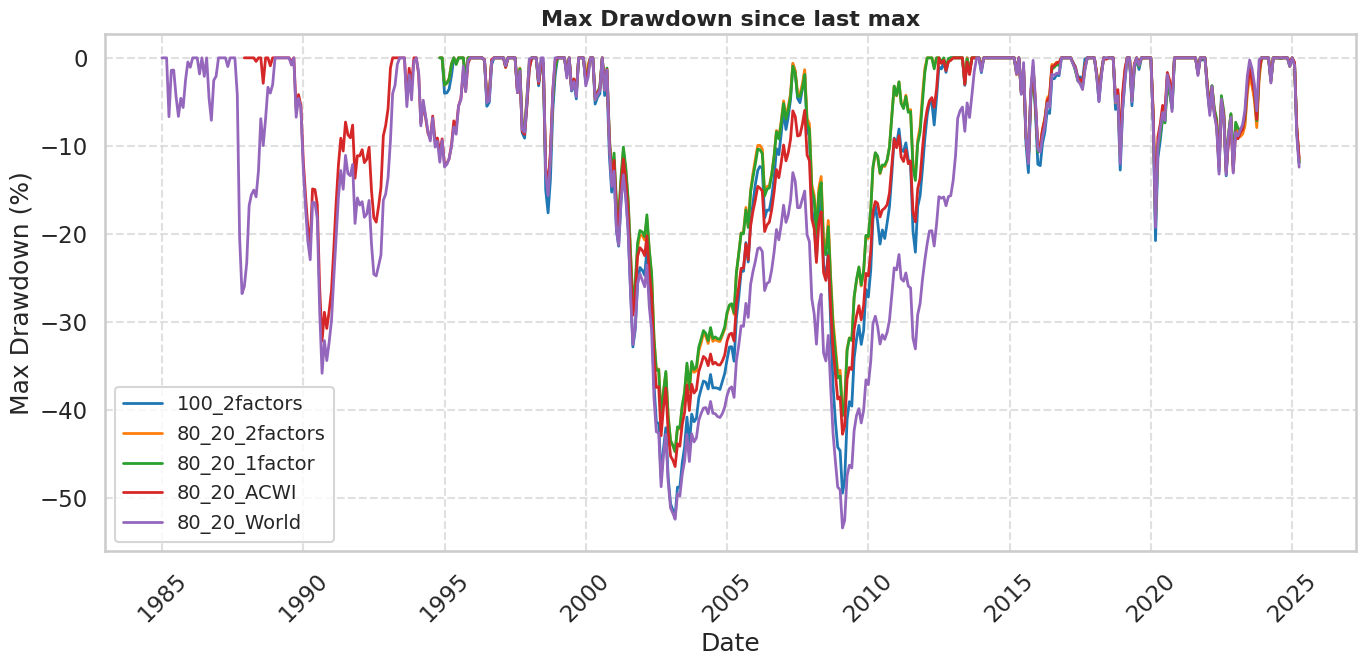

In [63]:
final_maxdrawdown = None

for portfolio_name in portfolios:

    portfolio = load_portfolio(portfolio_name)
    data, weights = prune_data_portfolio(portfolio)

    prices = compute_portfolio_prices(portfolio, portfolio_name)

    maxdrawdown = max_drawdown(prices)

    final_maxdrawdown = merge_results(final_maxdrawdown, maxdrawdown)

plot_max_drawdown(final_maxdrawdown)